In [38]:
import hoomd
import gsd.hoomd
import numpy
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
import freud

In [2]:
s = gsd.hoomd.Snapshot()
s.particles.N = 2
s.particles.types = ['A']
s.particles.typeid = [0,0]
s.particles.position = [[1,1,1], [2,1,2]]
s.particles.orientation = [[1, 0, 0, 0], [0, math.cos((math.pi)/4), 0.0, math.cos((math.pi)/4)]]
s.configuration.box = [8, 8, 8, 0, 0, 0]
s.particles.mass = [2] * 2

In [3]:
#Script in order to account for Intertia, which hopefully solves the line 9 problem of providing no torques
#The problem: adding the mass property to the particles breaks the line 4 command
general_positions = numpy.array([[0, 0, 0], [1, 0, 0]])

I_ref = numpy.array([[0.4, 0, 0],
                   [0, 0.4, 0],
                   [0, 0, 0.4]])
I_general = numpy.zeros(shape=(3,3))
for r in general_positions:
    I_general += I_ref + 1 * (numpy.dot(r, r) * numpy.identity(3) - numpy.outer(r, r))
    
I_diagonal, E_vec = numpy.linalg.eig(I_general)

R = E_vec.T

diagonal_positions = numpy.dot(R, general_positions.T).T

I_check = numpy.zeros(shape=(3,3))
for r in diagonal_positions:
    I_check += I_ref + 1 * (numpy.dot(r, r) * numpy.identity(3) - numpy.outer(r, r))

#mass = 1
#I = numpy.zeros(shape=(3,3))
#for r in central_position:
#    I += mass * (numpy.dot(r, r) * numpy.identity(3) - numpy.outer(r, r))
I_check

array([[0.8, 0. , 0. ],
       [0. , 1.8, 0. ],
       [0. , 0. , 1.8]])

In [4]:
s.particles.moment_inertia = [I_general[0, 0], I_general[1, 1], I_general[2, 2]] * 2
print(s.particles.moment_inertia[:])

[0.8, 1.7999999999999998, 1.7999999999999998, 0.8, 1.7999999999999998, 1.7999999999999998]


In [5]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=1)
sim.create_state_from_snapshot(s)

In [6]:
rigid = hoomd.md.constrain.Rigid()

rigid.body['dimer'] = {
    "constituent_types": ['A', 'A'],
    "positions": [[0, 0, -0.5], [0, 0, 0.5]],
    "orientations": [(1.0, 0.0, 0.0, 0.0), (1.0, 0, 0, 1.0)],
    "charges": [0.0, 0.0],
    "diameters": [1.0, 1.0]
}

In [7]:
integrator = hoomd.md.Integrator(dt=0.005, integrate_rotational_dof=True)

cell = hoomd.md.nlist.Cell(buffer=0.4)

lperp = 0.3
lpar = 1.0
sigmin = 2 * min(lperp, lpar)
sigmax = 2 * max(lperp, lpar)

gay_berne = hoomd.md.pair.aniso.GayBerne(nlist=cell, default_r_cut=2.5)
gay_berne.params[('A', 'A')] = dict(epsilon=1.0, lperp=lperp, lpar=lpar)
gay_berne.r_cut[('A', 'A')] = 2.5

In [8]:
sim.operations.integrator = integrator

In [9]:
integrator.rigid = rigid

In [10]:
#sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.5)

#kT = 1.5
rigid_centers_and_free = hoomd.filter.Rigid(("center", "free"))
nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
integrator.methods.append(nve)
integrator.forces.append(gay_berne)

In [11]:
logger = hoomd.logging.Logger(categories=['scalar'])
# Log all default quantities of the lj object
#logger += gay_berne
logger.add(gay_berne, quantities=['energy'])
#logger.add(cell, quantities=['pair_list'])

In [12]:
Table = hoomd.write.Table(output=open('gay_berne_log_different_directions.txt', mode='w', newline='\n'),
                          trigger = hoomd.trigger.Periodic(1), logger=logger)
sim.operations.writers.append(Table)

In [13]:
#sim.state.thermalize_particle_momenta(filter=rigid_centers_and_free, kT=kT)
sim.run(0)
#nvt.thermalize_thermostat_dof()

In [14]:
g = sim.state.get_snapshot()
g.particles.orientation

array([[1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.70710677, 0.        , 0.70710677]])

In [15]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
gsd_writer = hoomd.write.GSD(filename='traj_different_directions.gsd',
                             trigger=hoomd.trigger.Periodic(1),
                             mode='wb',
                             log=logger,
                             filter=hoomd.filter.All())
sim.operations.writers.append(gsd_writer)

In [16]:
sim.run(1000)

In [17]:
f = gsd.hoomd.open('traj_different_directions.gsd', 'rb')

In [18]:
endframe = f.read_frame(999)
endframe.particles.orientation

array([[-0.659559  ,  0.        ,  0.7516528 ,  0.        ],
       [ 0.        , -0.9978774 ,  0.        ,  0.06512038]],
      dtype=float32)

In [19]:
def distconvert(dist, lperp, lpar, ei, ej):
    sigmin = min(lperp, lpar) * 2
    H = 2 * (lperp**2) * np.identity(3) + ((lpar**2 - lperp**2) * (np.outer(ei, ei) + np.outer(ej, ej)))
    sigma = (np.dot((0.5*dist) , np.dot(np.linalg.inv(H), dist)))**(-2)
    gbdist = ((np.linalg.norm(dist) - sigma + sigmin) / sigmin)
    return np.abs(gbdist)

In [20]:
def phiconvert(dist, lperp, lpar, ei, ej):
    sigmin = min(lperp, lpar) * 2
    H = 2 * (lperp**2) * np.identity(3) + ((lpar**2 - lperp**2) * (np.outer(ei, ei) + np.outer(ej, ej)))
    sigma = (np.dot((0.5*dist) , np.dot(np.linalg.inv(H), dist)))**(-2)
    gbdist = np.dot((0.5*dist) , np.dot(np.linalg.inv(H), dist))
    return np.abs(gbdist)

In [50]:
# magnitudes
distances = []
# vectors
dist_vecs = []
# vectors adjusted to zeta
gbdists = []
# vectors adjusted to phi
phidists = []
# hoomd-calculated GB energies
energies = []
for frame in f:
    #Adjust for periodic boundaries
    #distvect = frame.particles.position[1] - frame.particles.position[0]
    #dx, dy, dz = frame.particles.position[1] - frame.particles.position[0]
    #dx = np.sign(dx) * (np.abs(dx) %(frame.configuration.box[0]/2))
    #dy = np.sign(dy) * (np.abs(dy) %(frame.configuration.box[1]/2))
    #dz = np.sign(dz) * (np.abs(dz) %(frame.configuration.box[2]/2))
    #distvect = np.array([dx, dy, dz])
    #distnorm = numpy.linalg.norm(distvect)
    #distances.append(distnorm)
    pts = frame.particles.position
    aq = freud.locality.AABBQuery(frame.configuration.box, pts)
    for pair in aq.query(pts, dict(num_neighbors=2)):
        dist_mag = max(0, pair[2])
        dist_vec = aq.points[1] - aq.points[0]
    distances.append(dist_mag)
    dist_vecs.append(dist_vec)
    print(aq.points)
    ei = frame.particles.orientation[0][:3]
    ei = ei / np.linalg.norm(ei)
    ej = frame.particles.orientation[1][:3]
    ej = ej / np.linalg.norm(ej)
    gbdists.append(distconvert(dist_vec, lperp, lpar, ei, ej))
    phidists.append(phiconvert(dist_vec, lperp, lpar, ei, ej))
    energies.append(frame.log['md/pair/aniso/GayBerne/energy'])


[[0.9989115 1.        0.9989115]
 [2.0010886 1.        2.0010886]]
[[0.99589795 1.         0.99589795]
 [2.004102   1.         2.004102  ]]
[[0.99151725 1.         0.99151725]
 [2.0084827  1.         2.0084827 ]]
[[0.98631185 1.         0.98631185]
 [2.013688   1.         2.013688  ]]
[[0.9806654 1.        0.9806654]
 [2.0193346 1.        2.0193346]]
[[0.9748087 1.        0.9748087]
 [2.0251913 1.        2.0251913]]
[[0.96886927 1.         0.96886927]
 [2.0311308  1.         2.0311308 ]]
[[0.96291345 1.         0.96291345]
 [2.0370865  1.         2.0370865 ]]
[[0.9569737 1.        0.9569737]
 [2.0430262 1.        2.0430262]]
[[0.9510641 1.        0.9510641]
 [2.048936  1.        2.048936 ]]
[[0.9451895 1.        0.9451895]
 [2.0548105 1.        2.0548105]]
[[0.93931484 1.         0.93931484]
 [2.0606852  1.         2.0606852 ]]
[[0.9334402 1.        0.9334402]
 [2.0665598 1.        2.0665598]]
[[0.9275655 1.        0.9275655]
 [2.0724344 1.        2.0724344]]
[[0.9216909 1.        0.92

[[0.16386144 1.         0.1638615 ]
 [2.8361385  1.         2.8361385 ]]
[[0.15798679 1.         0.15798685]
 [2.8420131  1.         2.8420131 ]]
[[0.15211216 1.         0.1521122 ]
 [2.8478878  1.         2.8478878 ]]
[[0.14623751 1.         0.14623757]
 [2.8537624  1.         2.8537624 ]]
[[0.14036286 1.         0.14036292]
 [2.8596373  1.         2.859637  ]]
[[0.13448821 1.         0.13448827]
 [2.865512   1.         2.8655117 ]]
[[0.12861356 1.         0.12861362]
 [2.8713865  1.         2.8713863 ]]
[[0.12273891 1.         0.12273897]
 [2.8772612  1.         2.877261  ]]
[[0.11686427 1.         0.11686433]
 [2.8831358  1.         2.8831356 ]]
[[0.11098962 1.         0.11098968]
 [2.8890104  1.         2.8890104 ]]
[[0.10511497 1.         0.10511503]
 [2.894885   1.         2.894885  ]]
[[0.09924033 1.         0.09924039]
 [2.9007597  1.         2.9007597 ]]
[[0.09336568 1.         0.09336574]
 [2.9066343  1.         2.9066343 ]]
[[0.08749104 1.         0.0874911 ]
 [2.912509   1.

[[-0.6762131   1.         -0.67621297]
 [ 3.676213    1.          3.676213  ]]
[[-0.6820877  1.        -0.6820876]
 [ 3.6820877  1.         3.6820877]]
[[-0.68796235  1.         -0.68796223]
 [ 3.6879623   1.          3.6879623 ]]
[[-0.693837    1.         -0.69383687]
 [ 3.693837    1.          3.693837  ]]
[[-0.6997116  1.        -0.6997115]
 [ 3.6997116  1.         3.6997116]]
[[-0.7055863  1.        -0.7055862]
 [ 3.7055862  1.         3.7055862]]
[[-0.71146095  1.         -0.7114608 ]
 [ 3.7114608   1.          3.7114608 ]]
[[-0.7173356   1.         -0.71733546]
 [ 3.7173357   1.          3.7173355 ]]
[[-0.7232102  1.        -0.7232101]
 [ 3.7232103  1.         3.72321  ]]
[[-0.72908485  1.         -0.72908473]
 [ 3.729085    1.          3.7290847 ]]
[[-0.73495954  1.         -0.7349594 ]
 [ 3.7349596   1.          3.7349594 ]]
[[-0.7408342   1.         -0.74083406]
 [ 3.7408342   1.          3.740834  ]]
[[-0.7467088  1.        -0.7467087]
 [ 3.7467089  1.         3.7467086]]
[[-

[[-1.5515355  1.        -1.5515352]
 [-3.4484646  1.        -3.4484646]]
[[-1.5574101  1.        -1.5574099]
 [-3.44259    1.        -3.44259  ]]
[[-1.5632848  1.        -1.5632845]
 [-3.4367154  1.        -3.4367154]]
[[-1.5691594  1.        -1.5691592]
 [-3.4308407  1.        -3.4308407]]
[[-1.575034   1.        -1.5750339]
 [-3.4249659  1.        -3.424966 ]]
[[-1.5809087  1.        -1.5809085]
 [-3.4190912  1.        -3.4190915]]
[[-1.5867833  1.        -1.5867832]
 [-3.4132166  1.        -3.4132168]]
[[-1.5926579  1.        -1.5926578]
 [-3.407342   1.        -3.4073422]]
[[-1.5985326  1.        -1.5985324]
 [-3.4014673  1.        -3.4014676]]
[[-1.6044073  1.        -1.6044071]
 [-3.3955927  1.        -3.395593 ]]
[[-1.610282   1.        -1.6102817]
 [-3.389718   1.        -3.3897183]]
[[-1.6161566  1.        -1.6161563]
 [-3.3838434  1.        -3.3838437]]
[[-1.6220312  1.        -1.622031 ]
 [-3.3779688  1.        -3.377969 ]]
[[-1.6279058  1.        -1.6279056]
 [-3.3720942  1

[[-1.7326736  1.        -1.732673 ]
 [-3.2673264  1.        -3.2673268]]
[[-1.7311456  1.        -1.7311451]
 [-3.2688544  1.        -3.2688549]]
[[-1.7296177  1.        -1.7296171]
 [-3.2703824  1.        -3.270383 ]]
[[-1.7280897  1.        -1.7280891]
 [-3.2719104  1.        -3.271911 ]]
[[-1.7265617  1.        -1.7265611]
 [-3.2734382  1.        -3.273439 ]]
[[-1.7250336  1.        -1.7250332]
 [-3.2749662  1.        -3.274967 ]]
[[-1.7235057  1.        -1.7235051]
 [-3.2764943  1.        -3.276495 ]]
[[-1.7219777  1.        -1.7219771]
 [-3.2780223  1.        -3.2780228]]
[[-1.7204497  1.        -1.7204491]
 [-3.2795503  1.        -3.2795508]]
[[-1.7189218  1.        -1.7189211]
 [-3.2810783  1.        -3.2810788]]
[[-1.7173938  1.        -1.7173932]
 [-3.2826064  1.        -3.2826068]]
[[-1.7158657  1.        -1.7158651]
 [-3.2841341  1.        -3.2841349]]
[[-1.7143377  1.        -1.7143371]
 [-3.2856622  1.        -3.285663 ]]
[[-1.7128098  1.        -1.7128091]
 [-3.2871902  1

[[-1.5050027  1.        -1.5050017]
 [-3.4949973  1.        -3.4949985]]
[[-1.5034748  1.        -1.5034736]
 [-3.4965253  1.        -3.4965265]]
[[-1.5019468  1.        -1.5019456]
 [-3.4980533  1.        -3.4980543]]
[[-1.5004188  1.        -1.5004176]
 [-3.499581   1.        -3.4995823]]
[[-1.4988908  1.        -1.4988896]
 [-3.5011091  1.        -3.5011103]]
[[-1.4973629  1.        -1.4973617]
 [-3.5026371  1.        -3.5026383]]
[[-1.4958348  1.        -1.4958336]
 [-3.5041652  1.        -3.5041664]]
[[-1.4943068  1.        -1.4943056]
 [-3.5056932  1.        -3.5056944]]
[[-1.4927789  1.        -1.4927776]
 [-3.5072212  1.        -3.5072224]]
[[-1.4912509  1.        -1.4912497]
 [-3.5087492  1.        -3.5087504]]
[[-1.4897228  1.        -1.4897217]
 [-3.510277   1.        -3.5102785]]
[[-1.4881948  1.        -1.4881936]
 [-3.511805   1.        -3.5118062]]
[[-1.4866669  1.        -1.4866656]
 [-3.513333   1.        -3.5133343]]
[[-1.4851389  1.        -1.4851377]
 [-3.514861   1

[[-1.3094198  1.        -1.3094181]
 [-3.6905804  1.        -3.690582 ]]
[[-1.3078917  1.        -1.30789  ]
 [-3.6921082  1.        -3.69211  ]]
[[-1.3063638  1.        -1.306362 ]
 [-3.6936362  1.        -3.6936378]]
[[-1.3048358  1.        -1.304834 ]
 [-3.6951642  1.        -3.6951659]]
[[-1.3033078  1.        -1.3033061]
 [-3.6966922  1.        -3.696694 ]]
[[-1.3017797  1.        -1.3017781]
 [-3.6982203  1.        -3.698222 ]]
[[-1.3002518  1.        -1.30025  ]
 [-3.6997483  1.        -3.69975  ]]
[[-1.2987238  1.        -1.298722 ]
 [-3.7012763  1.        -3.701278 ]]
[[-1.2971958  1.        -1.2971941]
 [-3.702804   1.        -3.702806 ]]
[[-1.2956678  1.        -1.2956661]
 [-3.704332   1.        -3.704334 ]]
[[-1.2941399  1.        -1.2941381]
 [-3.7058601  1.        -3.7058618]]
[[-1.2926118  1.        -1.29261  ]
 [-3.7073882  1.        -3.7073898]]
[[-1.2910838  1.        -1.2910821]
 [-3.7089162  1.        -3.7089179]]
[[-1.2895558  1.        -1.2895541]
 [-3.7104442  1

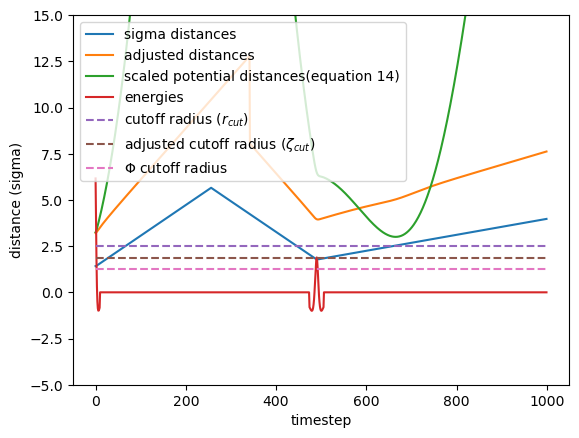

In [52]:
plt.figure()
plt.plot(distances, label = 'sigma distances')
plt.plot(gbdists, label = 'adjusted distances')
plt.plot(phidists, label = 'scaled potential distances(equation 14)')
plt.plot(energies, label='energies')
plt.xlabel('timestep')
plt.ylabel('distance (sigma)')
plt.plot(2.5 * numpy.ones_like(distances), ls = '--', label = 'cutoff radius ($r_{cut}$)')
plt.plot(((2.5 - sigmax + sigmin)/sigmin) * numpy.ones_like(distances), ls = '--', label = 'adjusted cutoff radius ($\zeta_{cut}$)')
plt.plot(2.5 / sigmax * np.ones_like(distances), ls='--', label='$\Phi$ cutoff radius')
plt.ylim(-5, 15)
plt.legend()

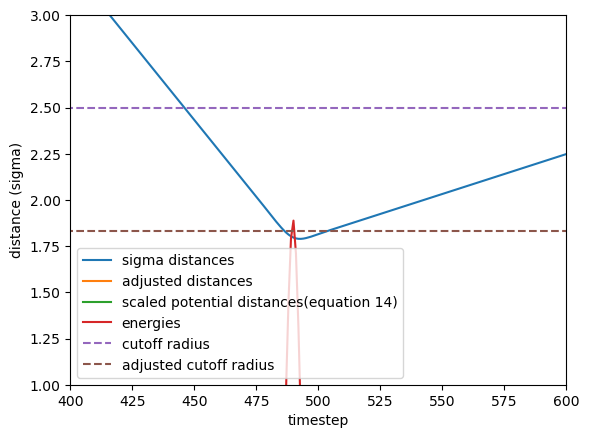

In [37]:
plt.figure()
plt.plot(distances, label = 'sigma distances')
plt.plot(gbdists, label = 'adjusted distances')
plt.plot(phidists, label = 'scaled potential distances(equation 14)')
plt.plot(energies, label='energies')

plt.xlabel('timestep')
plt.ylabel('distance (sigma)')
plt.plot(2.5 * numpy.ones_like(distances), ls = '--', label = 'cutoff radius')
plt.plot(((2.5 - sigmax + sigmin)/sigmin) * numpy.ones_like(distances), ls = '--', label = 'adjusted cutoff radius')
#plt.axvline(x = 490, color = 'g', label = 'vertical line') #This is the function for a vertical line but
plt.axis([400, 600, 1, 3])
plt.legend()

In [24]:
#To do list:
# Get the quaternions like we did the positions so we can calculate adjusted distances
# Plot the adjusted distances
# Put a veritcal line on the plot at index where energies hit zero
# Make a zoomed in plot of the interesting area (index 0-10)